In [532]:
import os
import argparse
from plantcv import plantcv as pcv 
#import analyze_area
import json
import cv2
from matplotlib import pyplot as plt
import numpy as np
import csv
import cluster_jordan 
import math
import show_objects

# set to "plot" to see image at every step (takes longer)
pcv.params.debug = "plot"
#sets the size of the debug images. Smaller values will run faster. A larger value was chosen for demonstration
pcv.params.dpi=100

In [533]:
#Load the image
imagelink = f"./test_images/dedicated_scale/IMG_7459.JPG"
image = cv2.imread(imagelink)

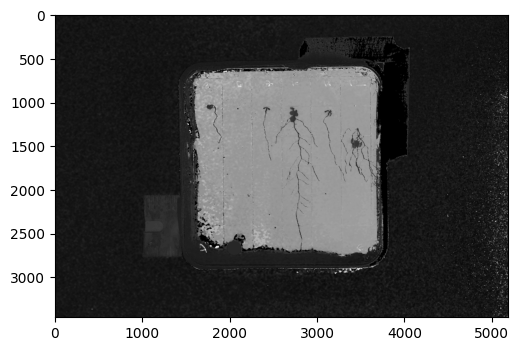

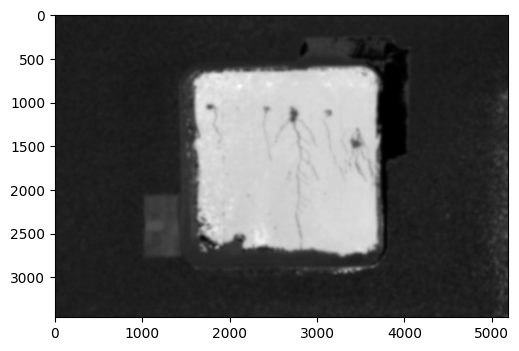

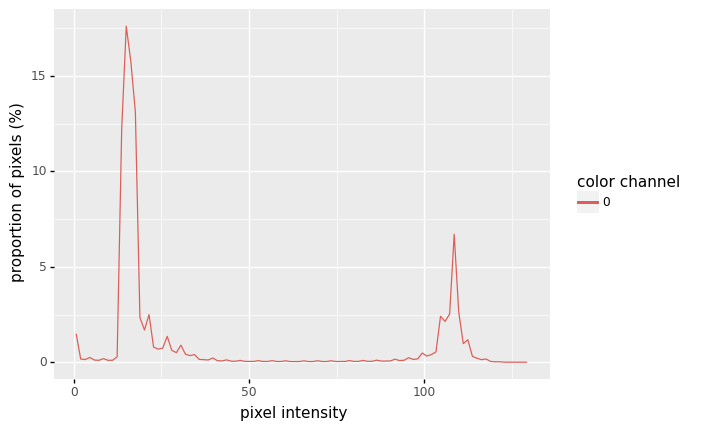

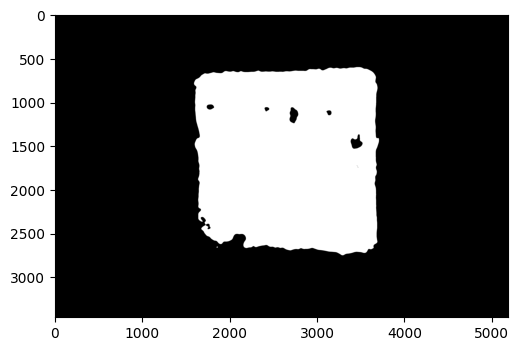

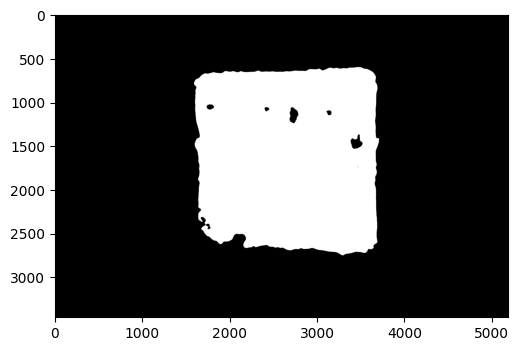

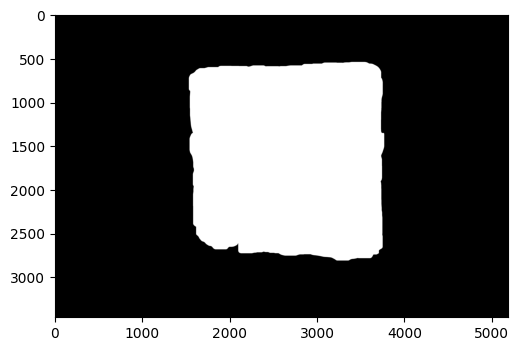

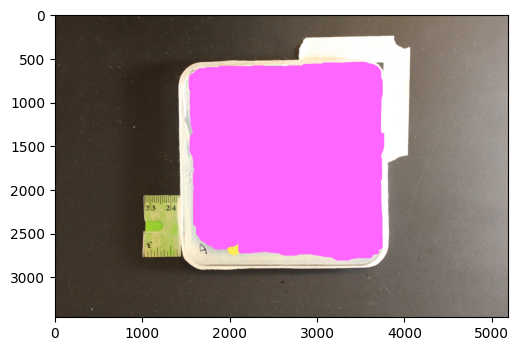

In [534]:
#plate detection using thresholding - in this tutorial it is only used for cropping to the plate area

#convert image to grayscale using "h" channel of HSV colorspace. The colorspace and channel will depend on the 
# lighting and background of the image. For some imagesets this method may not be the best option and edge detection 
# will be more effective. For an example of this please see the plate as scale demo
gray = pcv.rgb2gray_hsv(rgb_img=image, channel="h")
#apply a gaussian blur to reduce noise when thresholding
blur = pcv.gaussian_blur(img=gray, ksize=(101, 101), sigma_x=0, sigma_y=None)
#this function creates a histogram of the pixel intensities in the image. It is very useful for determining threshold values
hist_figure1, hist_data1 = pcv.visualize.histogram(blur, hist_data=True)
#Based on the histogram we chose 80 as an appropriate threshold value
thresh = pcv.threshold.binary(gray_img=blur, threshold=80, max_value=325, object_type="light")
#this step fills in the holes in the binary image. The holes in this case are due to the seedlings
fill = pcv.fill(bin_img=thresh, size=350000)
#fill remaining holes and then filter out noise if any is present
dilate = pcv.dilate(gray_img=fill, ksize=120, i=1)
#identify objects from binary threshold image
id_objects, obj_hierarchy = pcv.find_objects(img=image, mask=dilate)
#Additional test to determine if any noise in the image was detected as an object along with the scale. If there is it applies 
# erosion and dilation to filter it out
if len(id_objects)>1:
    erode = pcv.erode(gray_img=dilate, ksize=150, i=1)
    dilate = pcv.dilate(gray_img=erode, ksize=150, i=1)
    id_objects, obj_hierarchy = pcv.find_objects(img=image, mask=dilate)

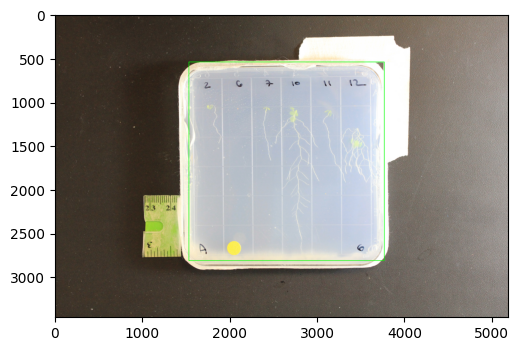

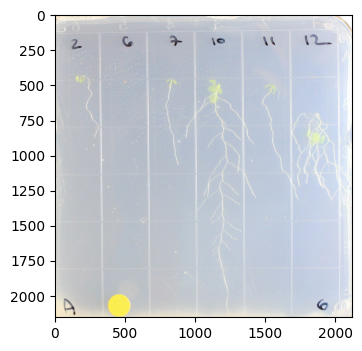

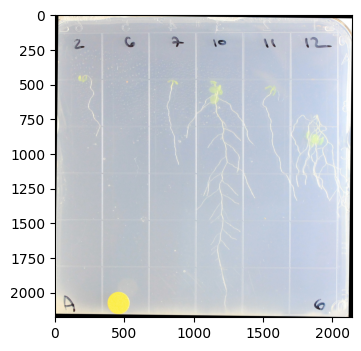

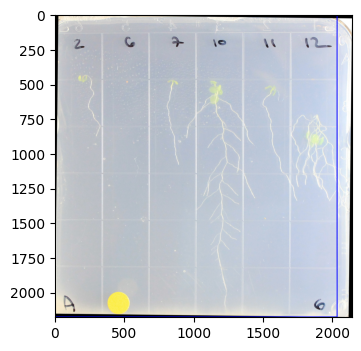

In [535]:
#These steps give us the size of the plate and then crop the image so only the plate area is showing - doing this not only saves
#time processing the image but also is needed for precisely locating the seedlings
plate = id_objects[0]
x,y,w,h = cv2.boundingRect(plate)
img = image[(y):(y+h),(x):(x+w)]
rect = cv2.minAreaRect(plate)
box = cv2.boxPoints(rect)
box = np.int0(box)
angle = rect[2]

plate_crop= pcv.auto_crop(img= image, obj=plate, padding_x=-60, padding_y=-60, color="image")

#this rotates the plate image if it is needed
if angle < 4.0 and angle > -4.0:
    plate_crop = pcv.transform.rotate(plate_crop, angle, False)
else: 
    plate_crop = pcv.transform.rotate(plate_crop, angle-90, False)
shape=plate_crop.shape
#this additional cropping step is specific to this image set which always has glare on the right side of the plate
plate_crop = pcv.crop(img = plate_crop,x=0,y=0,h=shape[0], w=int(shape[1]*0.95))

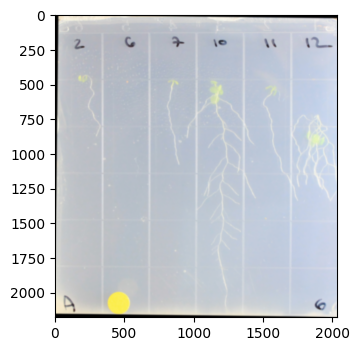

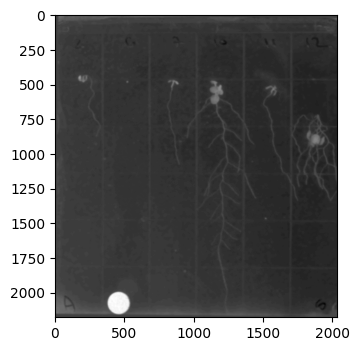

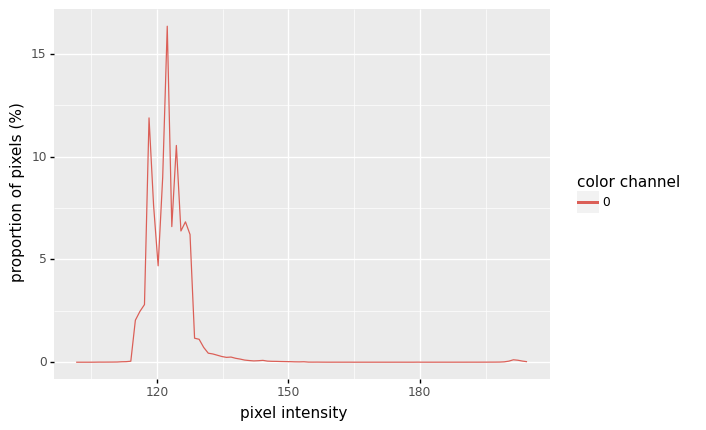

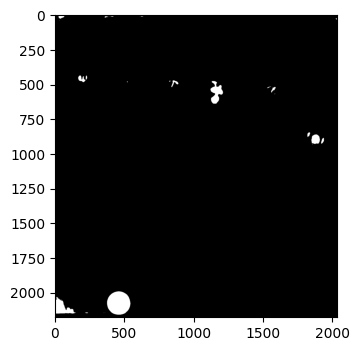

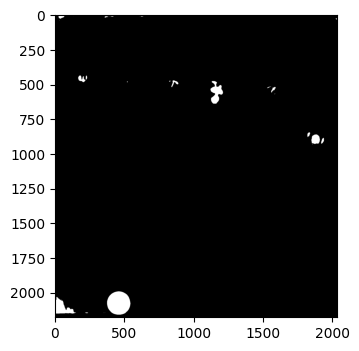

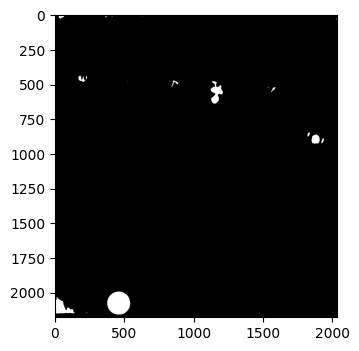

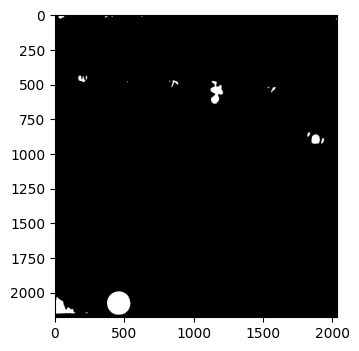

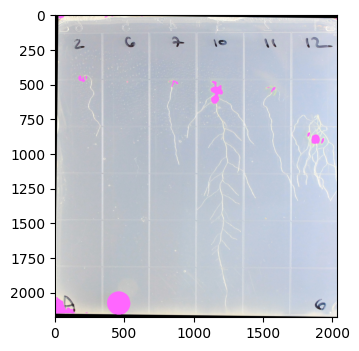

In [536]:
#thresholding step of leaf identification

#apply gaussian blur for better thresholding
blur = pcv.gaussian_blur(img=plate_crop, ksize=(21, 21), sigma_x=0, sigma_y=None)
#convert image to b/w using the b channel of lab colorspace
b = pcv.rgb2gray_lab(rgb_img=blur, channel="b")

#this function creates a histogram of the pixel intensities in the image. It is very useful for determining threshold values
hist_figure1, hist_data1 = pcv.visualize.histogram(b, hist_data=True)

avg = np.average(plate_crop)
std = np.std(plate_crop)
#checks if image is overexposed and low contrast - if so applies histogram equalization and adjusts threshold.
if avg > 220 and std < 25:
    b = pcv.hist_equalization(b)
    hist_figure1, hist_data1 = pcv.visualize.histogram(b, hist_data=True)
    t = 251
#If not then the threshold of 140 is chosen based on the histogram of pixel intensities
else: 
    t = 140
b_thresh = pcv.threshold.binary(gray_img=b, threshold= t, max_value=255, object_type="light")

# filling in small gaps within each leaf
b_thresh = pcv.closing(gray_img=b_thresh)
#eroding and dilating to filter out noise
b_thresh = pcv.erode(gray_img = b_thresh, ksize = 3, i = 1)
b_thresh = pcv.dilate(gray_img=b_thresh, ksize = 3, i = 1)
#identify all objects from thresholded image
id_objects, obj_hierarchy = pcv.find_objects(img=plate_crop, mask=b_thresh)


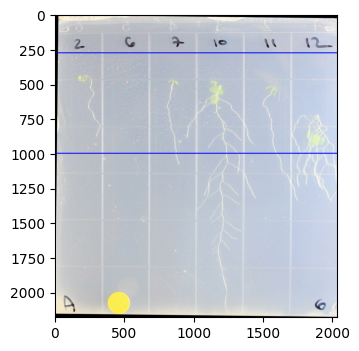

In [537]:
#define ROI
#shape is the size of the cropped image shape[1] is the width and shape[0] is the height
shape = np.shape(plate_crop)
#For this image set the ROI begins 1/8 of the way down (vertically) from the top of the plate and is 1/3 of the plate long. It is as wide as the image
roi_contour, roi_hierarchy = pcv.roi.rectangle(img=plate_crop, x=0, y=shape[0]/8, h=shape[0]/3, w=shape[1])

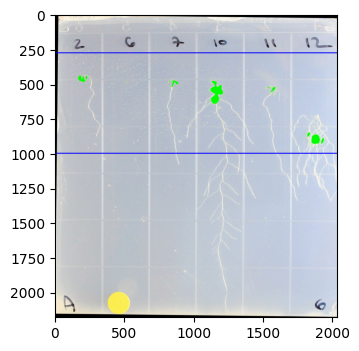

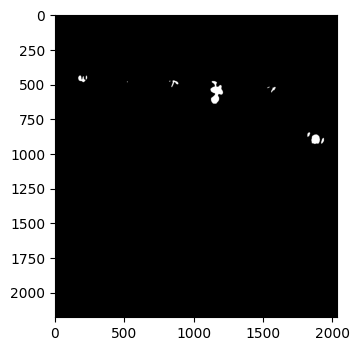

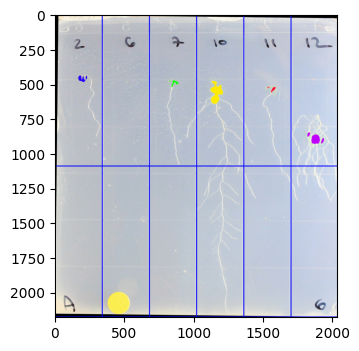

This function has been updated to include object hierarchy so object holes can be included


In [538]:
#Identifies all the objects within the defined region of interest
roi_objects, hierarchy, kept_mask, obj_area = pcv.roi_objects(img=plate_crop, 
                                                              roi_contour=roi_contour, roi_hierarchy=roi_hierarchy,
                                                              object_contour=id_objects, obj_hierarchy=obj_hierarchy, roi_type="partial")

#clustering defined leaves into individual plants using predefined rows/cols
#We are using a slightly modified version of the cluster contours function here (found in the file cluster_jordan.py)
clusters_i, contours, hierarchies = cluster_jordan.cluster_contours(img=plate_crop, roi_objects=roi_objects, 
                                                         roi_obj_hierarchy=hierarchy, nrow=2, ncol=6, show_grid=True)
#prevents extra debug images - change from None to "plot" to see all steps
pcv.params.debug = None
#splits the clusters into individual images for analysis
output_path, imgs, masks = cluster_jordan.cluster_contour_splitimg(rgb_img=plate_crop,
                                                        grouped_contour_indexes=clusters_i, contours=contours, 
                                                        hierarchy=hierarchies)

In [539]:
#cycles through the individual rosettes identified in the previous step and 
#calculates the image moment (number of pixels making up each rosette)
#it also looks for issues with leaf identification by comparing the number of pixels 
#found in the rosette to the minimum enclosing circle around the rosette. If the difference between the two
#is too large it flags the leaf as suspicious and prints a warning - this warning can be recorded in order to manually
#revisit any possibly problematic measurements or to more simply eliminate all suspicious measurements from the dataset
sus = False
num_plants = 0
areas = {}

for i in range(0,6):
    pos = i+1
    if clusters_i[i][0] != None:
        id_objects, obj_hierarchy = pcv.find_objects(img=imgs[num_plants], mask=masks[num_plants])
        obj, mask1 = pcv.object_composition(img=imgs[num_plants], contours=id_objects, hierarchy=obj_hierarchy)
        m = cv2.moments(obj)
        area = m['m00']
        num_plants += 1
        center, expect_r = cv2.minEnclosingCircle(obj)
        r = math.sqrt(area/math.pi)
        leaf_error = False
        if r <= 0.35*expect_r:
            leaf_error = True
            sus = True
            print(f"warning: there may be an error detecting leaf {pos}")

        areas[pos] = area
    else:
        areas[pos] = 0
print(areas)

{1: 1501.0, 2: 21.5, 3: 836.5, 4: 7681.5, 5: 553.0, 6: 4274.5}


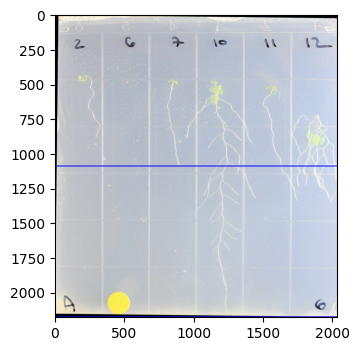

In [540]:
pcv.params.debug = "plot"

#These next steps show how the dedicated scale from this image was identified and also used to quantify leaf area
#The scale in this image set was always in in the bottom half of the plate so our first step is to crop to that region
#to save processing power and more easily seperate the scale from the background
shape=plate_crop.shape
scale_crop = pcv.crop(img = plate_crop,x=0,y=int(shape[0]/2),h=int(shape[0]/2), w=shape[1])

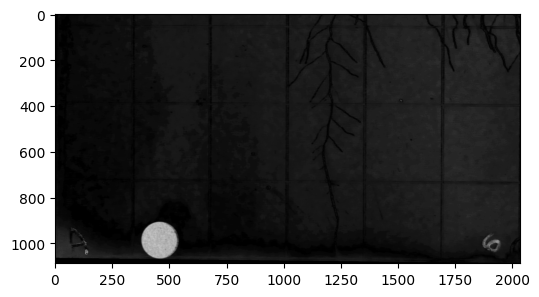

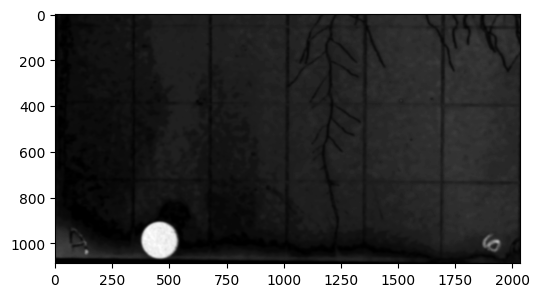

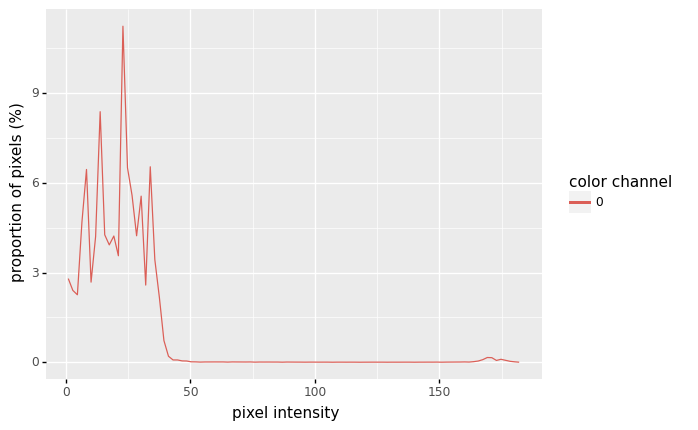

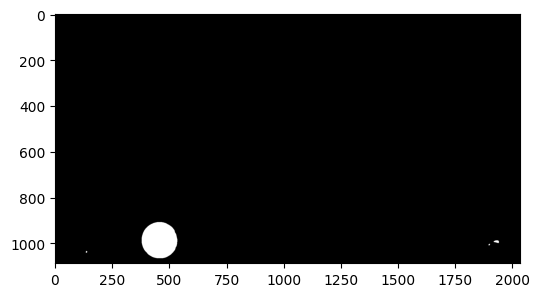

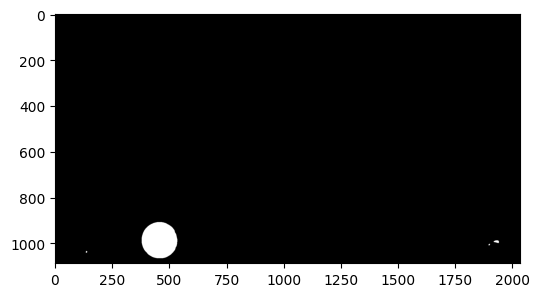

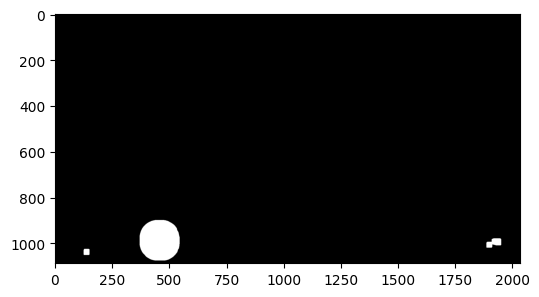

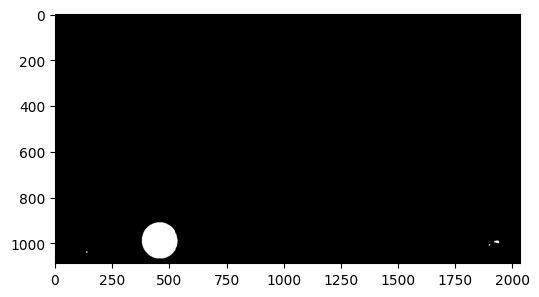

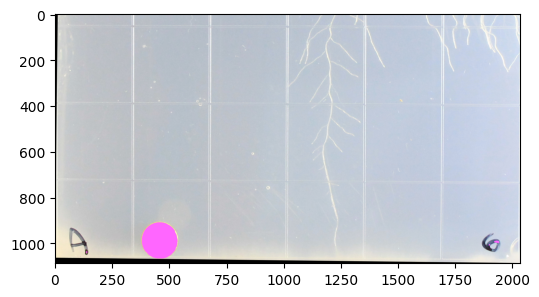

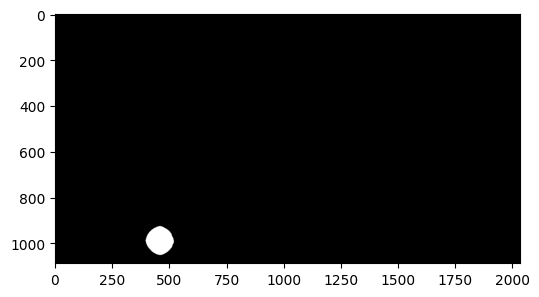

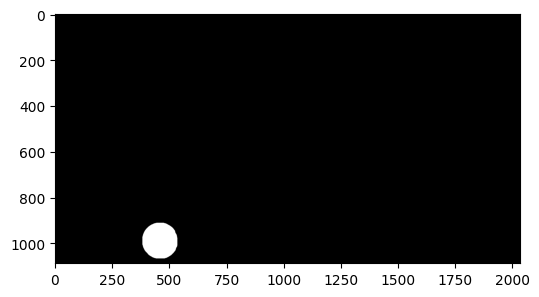

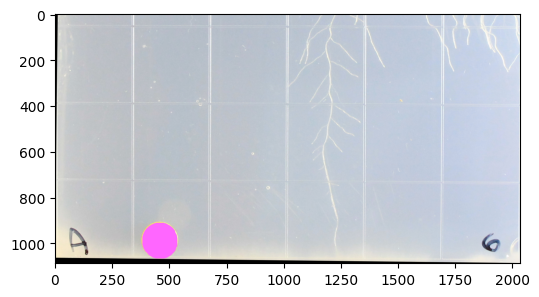

In [541]:
#this step identifies scale (circular sticker) using binary thresholding. 
# Because this image set had scales of different colors multiple color channels are used to ID the scale

#first we try the "s" channel of hsv colorspace because most of the stickers are more saturated than their background
scale = pcv.rgb2gray_hsv(rgb_img=scale_crop, channel="s")

#a_scale = pcv.hist_equalization(a_scale)
scale = pcv.gaussian_blur(img=scale, ksize=(21, 21), sigma_x=0, sigma_y=None)
hist_figure1, hist_data1 = pcv.visualize.histogram(scale, hist_data=True)
scale_thresh = pcv.threshold.binary(gray_img=scale, threshold=100, max_value=255, object_type="light")
scale_thresh = pcv.closing(gray_img=scale_thresh)
scale_thresh = pcv.dilate(gray_img=scale_thresh, ksize = 20, i=1)
scale_thresh = pcv.erode(gray_img=scale_thresh, ksize = 20, i=1)
id_scale, obj_hierarchy = pcv.find_objects(img=scale_crop, mask=scale_thresh)

#Additional test to determine if any noise in the image was detected as an object along with the scale. 
# If there was it applies erosion and dilation to filter it out
if len(id_scale) > 1:
    erode = pcv.erode(gray_img=scale_thresh, ksize = 30, i=1)
    dilate = pcv.dilate(gray_img=erode, ksize = 30, i=1)
    id_scale, obj_hierarchy = pcv.find_objects(img=scale_crop, mask=dilate)

#some sticker colors are less saturated so we try another color channel
if len(id_scale) == 0:
    scale = pcv.rgb2gray_lab(rgb_img=scale_crop, channel="a")
    scale = pcv.hist_equalization(scale)
    scale = pcv.gaussian_blur(img=scale, ksize=(21, 21), sigma_x=0, sigma_y=None)
    #histogram equalization helps when stickers have a low contrast compared with the rest of the image
    hist_figure1, hist_data1 = pcv.visualize.histogram(scale, hist_data=True)
    scale_thresh = pcv.threshold.binary(gray_img=scale, threshold=2, max_value=255, object_type="dark")

    id_scale, obj_hierarchy = pcv.find_objects(img=scale_crop, mask=scale_thresh)

#Additional test to determine if any noise in the image was detected as an object along with the scale. 
# If there was it applies erosion and dilation to filter it out
if len(id_scale) > 1:
    erode = pcv.erode(gray_img=scale_thresh, ksize = 30, i=1)
    dilate = pcv.dilate(gray_img=erode, ksize = 30, i=1)
    id_scale, obj_hierarchy = pcv.find_objects(img=scale_crop, mask=dilate)



In [542]:
#since the scale is always a circle in these image sets we will find the minimum enclosing circle around 
#the scale object and use that for our area conversions. This step can also be used to check that the scale was
#correctly identified by comparing the area of the scale object to the min enclosing circle area. If these two are too far
#apart it is likely the scale was not correctly identified
count = 0
for object in id_scale:
    m = cv2.moments(object)
    pixels = m['m00']
    (x,y), expect_r = cv2.minEnclosingCircle(object)
    area =(expect_r ** 2)*math.pi
    #this checks that the object is large enough to be the scale and that it fills most of its enclosing circle
    if pixels >= 0.75*area and area > 8000:
        scale_pixels = area
        pixels_per_mm2 = scale_pixels/30.7 #the stickers are always 30.7mm^2
        print("scale detected")
        break

scale detected


In [543]:
#first the raw pixel counts for each rosette
print("raw pixels")
print(areas)

converted_areas = {}

#and then we convert the pixel counts to mm^2 using the conversion factor calculated from the dedicated scale
for pos, area in areas.items():
    converted_areas[pos] = area/pixels_per_mm2
print("areas in mm^2")
print(converted_areas)

raw pixels
{1: 1501.0, 2: 21.5, 3: 836.5, 4: 7681.5, 5: 553.0, 6: 4274.5}
areas in mm^2
{1: 2.308452224068955, 2: 0.03306577136407896, 3: 1.2864891974907933, 4: 11.81370803410105, 5: 0.8504823983411939, 6: 6.5739367300351415}
